#**Building CNN Models: Code transcript**

**Contents:**
1. Loading Dataset Images
2. (Data Preprocessing: CLAHE)
3. Data Splitting
4. Data Preprocessing - Data Augmentation
5. Simple CNN Model Architecture \
  5.1. Model Architecture \
  5.2. Running Simple CNN Model \
  5.3. Training and Validation Accuracy and Loss graphs \
  5.4. Classification Report \
  5.5. Confusion Matrix \
  5.6. Display test sample images with true & predicted labels \
  5.7. ROC Curve
  
6. ResNet50 Model Architecture \
  (6.1. Normalisation) \
  6.2. Model architecture   
  (6.3. Assigning Class Weights) \
  6.4. Running ResNet50 Model \
  6.5. Classification Report \
  6.6. Confusion Matrix \
  6.7. Display test sample images with true & predicted labels \
  6.8. Training and Validation Accuracy and Loss graphs \
  6.9. ROC Curve

7. VGG-16 Model Architecture \
  (7.1. Normalisation) \
  7.2. Model architecture \
  (7.3. Focal loss function) \
  7.4. Running VGG-16 Model \
  7.5. Classification Report \
  7.6. Confusion Matrix \
  7.7. Display test sample images with true & predicted labels \
  7.8. Training and Validation Accuracy and Loss graphs \
  7.9. ROC Curve


\
**Note:**
- (Steps in brackets were not implemented in the final model architecture but code transcript is included)
- The following executable code & outputs produce the final model of each architecture


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/AIML_CW'

#**1. Loading Dataset Images**
- Dataset = 501 images
- Consisting of 300 normal images, 100 cataracts images, 101 glaucoma images
- Images were loaded, resized, converted to RGB, returned as array with corresponding labels


In [ ]:
import os

normal = os.path.join(path,'1_normal')
cataract = os.path.join(path,'2_cataract')
glaucoma = os.path.join(path,'3_glaucoma')

print("Number of normal images", len(os.listdir(normal)))
print("Number of cataract images", len(os.listdir(cataract)))
print("Number of glaucoma images", len(os.listdir(glaucoma)))

Number of normal images 300
Number of cataract images 100
Number of glaucoma images 101


In [ ]:
# function to load images, resize, RGB, output images array & corresponding labels

import cv2
import numpy as np

def load_images(directories, max_images=501):
    """
    Reads images from three subdirectories, ensuring no more than 501 images are loaded in total.

    Parameters:
        directories (list): A list of the sub-directory paths.
        max_images (int): Maximum total number of images to load (501).

    Returns:
        images: Image data as an array.
        labels: Labels of each image as an array.
    """
    # initiate empty lists
    images = []
    labels = []
    total_images_loaded = 0  # counter: number of images loaded

    for label, sub_dir in enumerate(directories):
        for file_name in os.listdir(sub_dir):
            if total_images_loaded >= max_images:
                break  # stop if total images loaded reaches the maximum limit

            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # resize to the same
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
                images.append(img)
                labels.append(label)
                total_images_loaded += 1  # increase counter


        if total_images_loaded >= max_images:
            break

    return np.array(images), np.array(labels)

#**2. Data Preprocessing - CLAHE (Not implemented)**
- CLAHE (Contrast Limited Adaptive Histogram Equalisation) was applied in an VGG-16 model iteration for contrast adjustment
- Did not significantly affect model performance hence was not implemented in final VGG-16 model
- Images were loaded in, CLAHE was applied, resized, and returned as an array with corresponding labels

In [ ]:
import cv2
import numpy as np
import os

## applies CLAHE to images
def apply_CLAHE_color(image):
    """
    Apply CLAHE to the L-channel of the LAB color space of an image.

    Parameters:
        image: Input RGB image.

    Returns:
        numpy.ndarray: CLAHE-enhanced RGB image.
    """
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel (intensity)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge back the LAB channels
    lab_clahe = cv2.merge((l_clahe, a, b))

    # Convert back to RGB color space
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)


## load images, apply CLAHE, append to array
def load_images(directories, max_images=501):
    """
    Reads images from three subdirectories, ensuring no more than 501 images are loaded in total.

    Parameters:
        directories (list): A list of the sub-directory paths.
        max_images (int): Maximum total number of images to load (501).

    Returns:
        images: Image data as an array.
        labels: Labels of each image as an array.
    """
    # initiate empty lists
    images = []
    labels = []
    total_images_loaded = 0  # counter: number of images loaded

    for label, sub_dir in enumerate(directories):
        for file_name in os.listdir(sub_dir):
            if total_images_loaded >= max_images:
                break  # stop if total images loaded reaches the maximum limit

            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # resize to 224x224
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

                # apply CLAHE
                img = apply_CLAHE_color(img)

                images.append(img)
                labels.append(label)
                total_images_loaded += 1  # increase counter


        if total_images_loaded >= max_images:
            break

    return np.array(images), np.array(labels) #return 2 arrays

In [ ]:
# applying function
images, labels = load_images([normal, cataract, glaucoma], 501)

# labels assigned based on order of directories
  # 0 = normal
  # 1 = cataracts
  # 2 = glaucoma

In [ ]:
# checkpoint
print("Total images loaded:", len(images))
print("Images shape:", images.shape) # 501 images across all directories
print("Labels shape:", labels.shape) # corresponding labels

print(len(images))
print(len(labels))

Total images loaded: 501
Images shape: (501, 224, 224, 3)
Labels shape: (501,)
501
501


#**3. Data Splitting**
- Images are then split into training, validation and testing datasets
- 70% training, 15% validation, 15% testing

In [ ]:
import numpy as np

## defining data splitting function
# ensures data subsets are proportional for all classifications
# ensures images are randomly allocated in each subset

def split_images_and_labels(ds, labels, train_split, val_split, test_split, shuffle=True, shuffle_seed=25):
    """
    Splits images and corresponding labels into training, validation, and test sets.

    Args:
    - ds : image dataset
    - labels : image labels
    - train_split : training data
    - val_split : validation data
    - test_split : testing data
    - shuffle : shuffle the data before splitting
    - shuffle_seed : random seed for reproducibility

    Returns:
    - train_ds, val_ds, test_ds: subsets of the dataset.
    - train_labels, val_labels, test_labels: Corresponding labels of data subsets
    """
    ds_size = len(ds)

    # check that dataset and labels have the same size
    assert len(ds) == len(labels), "Dataset and labels must have the same length."

    if shuffle:
        np.random.seed(shuffle_seed)  # seed for reproducibility
        indices = np.arange(ds_size)  # generate indices
        np.random.shuffle(indices)  # shuffle indices

        # apply the shuffle to both dataset and labels
        ds = np.array(ds)[indices]
        labels = np.array(labels)[indices]

    # calculate sizes for each split
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # split the dataset and labels
    train_ds = ds[:train_size]
    val_ds = ds[train_size:train_size + val_size]
    test_ds = ds[train_size + val_size:]

    train_lab = labels[:train_size]
    val_lab = labels[train_size:train_size + val_size]
    test_lab = labels[train_size + val_size:]

    return train_ds, val_ds, test_ds, train_lab, val_lab, test_lab


In [ ]:
# generating datasets
train_ds, val_ds, test_ds, train_lab, val_lab, test_lab = split_images_and_labels(images, labels, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_seed=25)

# checkpoint
print(len(images))
print(len(train_ds)) # 350 images
print(len(val_ds)) # 75 images
print(len(test_ds)) # 76 images

# check labels
print(len(train_lab))
print(len(val_lab))
print(len(test_lab))

501
350
75
76
350
75
76


#**4. Data Preprocessing - Data Augmentation**
- Slight rotations of 20 degrees
- Horizontal and vertical shift of 10% - as to overly shift critical features out of view
- Zoom 20% emphasizes emphasizes details
- Horizontal flip as left/right eye distinctions
- Fill mode nearest - fills in pixels created by transformations w/ nearest pixel value
- brightness and shear transformations were removed as to not disturb characteristic structures (i.e. blood vessels)

In [ ]:
#rescaling images for ImageDataGenerator
train_ds_res = train_ds / 255.0
val_ds_res = val_ds / 255.0
test_ds_res = test_ds / 255.0


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1, #reduced width & height shift from 0.2
    height_shift_range=0.1, #removed shear_range=0.2
    zoom_range=0.1, #limiting zoom
    horizontal_flip=True,
    fill_mode='nearest')


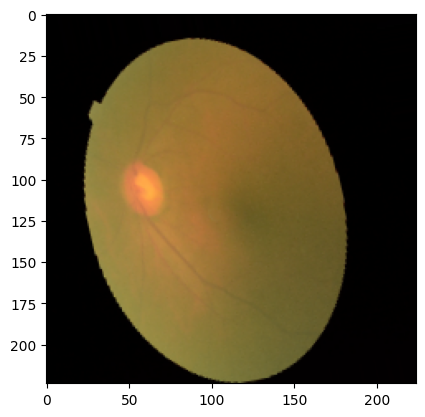

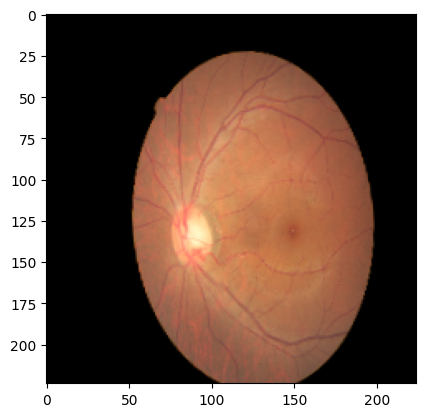

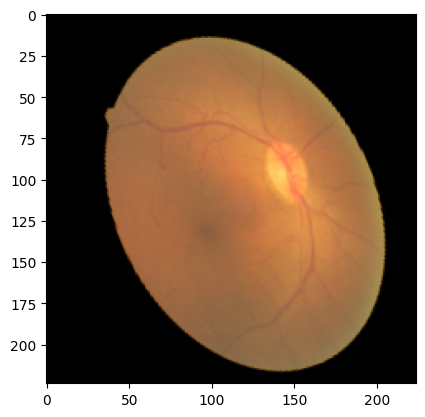

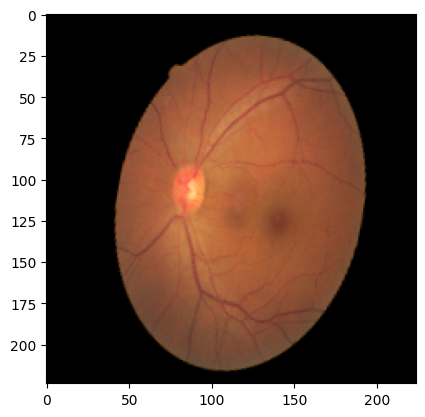

In [ ]:
## testing what data augmented images actually look like

import matplotlib.pyplot as plt

# display 5 augmented image & corresponding labels
for _ in range(5):
    img, label = next(datagen.flow(train_ds_res, train_lab, batch_size=1))
    plt.imshow(img[0])
    plt.show()

#**5. Simple CNN Model Architecture**

##**5.1. Model Architecture**
- Normalisation of pixel values by a scale of 1/255
- 3 hierarchical convolutional layers - 32, 64, 128 filters - 3x3 kernel filtering for feature and pattern extraction
- 3 Max-pooling layers (2x2 filter) downsamples feature mapsize
- Flatten layer into 1D vector
- Fully connected dense layer takes weighted sum of previous layer outputs
- Final output - 3 neurons for 3 classifications

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, BatchNormalization

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),

    Rescaling(1.0/255), # normalisation
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer ,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
# reshaping labels due to multi-class data

import tensorflow

train_lab_cat = tensorflow.keras.utils.to_categorical(train_lab, num_classes=3)
# also for the test set
test_lab_cat = tensorflow.keras.utils.to_categorical(test_lab, num_classes=3)
val_lab_cat = tensorflow.keras.utils.to_categorical(val_lab, num_classes=3)

##**5.2. Running Simple CNN Model**
- Ran for 20 epochs

In [ ]:
history = model.fit(
    datagen.flow(train_ds, train_lab_cat, batch_size=32),
    validation_data=(val_ds, val_lab_cat),
    epochs=20,
    shuffle = True

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.4214 - loss: 2.1738 - val_accuracy: 0.6800 - val_loss: 0.8747
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.5752 - loss: 1.0128 - val_accuracy: 0.6800 - val_loss: 0.8439
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5565 - loss: 1.0119 - val_accuracy: 0.6800 - val_loss: 0.8529
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.5302 - loss: 1.0231 - val_accuracy: 0.6800 - val_loss: 0.8121
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.5627 - loss: 0.9745 - val_accuracy: 0.6800 - val_loss: 0.8302
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.5945 - loss: 0.9504 - val_accuracy: 0.7067 - val_loss: 0.8253
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.6501 - loss: 0.8809 - val_accuracy: 0.7467 - val_loss: 0.7612
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6256 - loss: 0.8843 - val_accuracy: 0.6933 - val_loss:

##**5.3. Training and Validation Accuracy and Loss graphs**


In [ ]:
epochs = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**5.4. Classification report**


In [ ]:
## model predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_prob = model.predict(test_ds)
y_pred  = y_pred_prob.argmax(axis=1)

print("Accuracy:", accuracy_score(test_lab, y_pred))
print("Classification Report:")
print(classification_report(test_lab, y_pred))

##**5.5. Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm  = confusion_matrix(test_lab, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

##**5.6. Display test sample images with true & predicted labels**

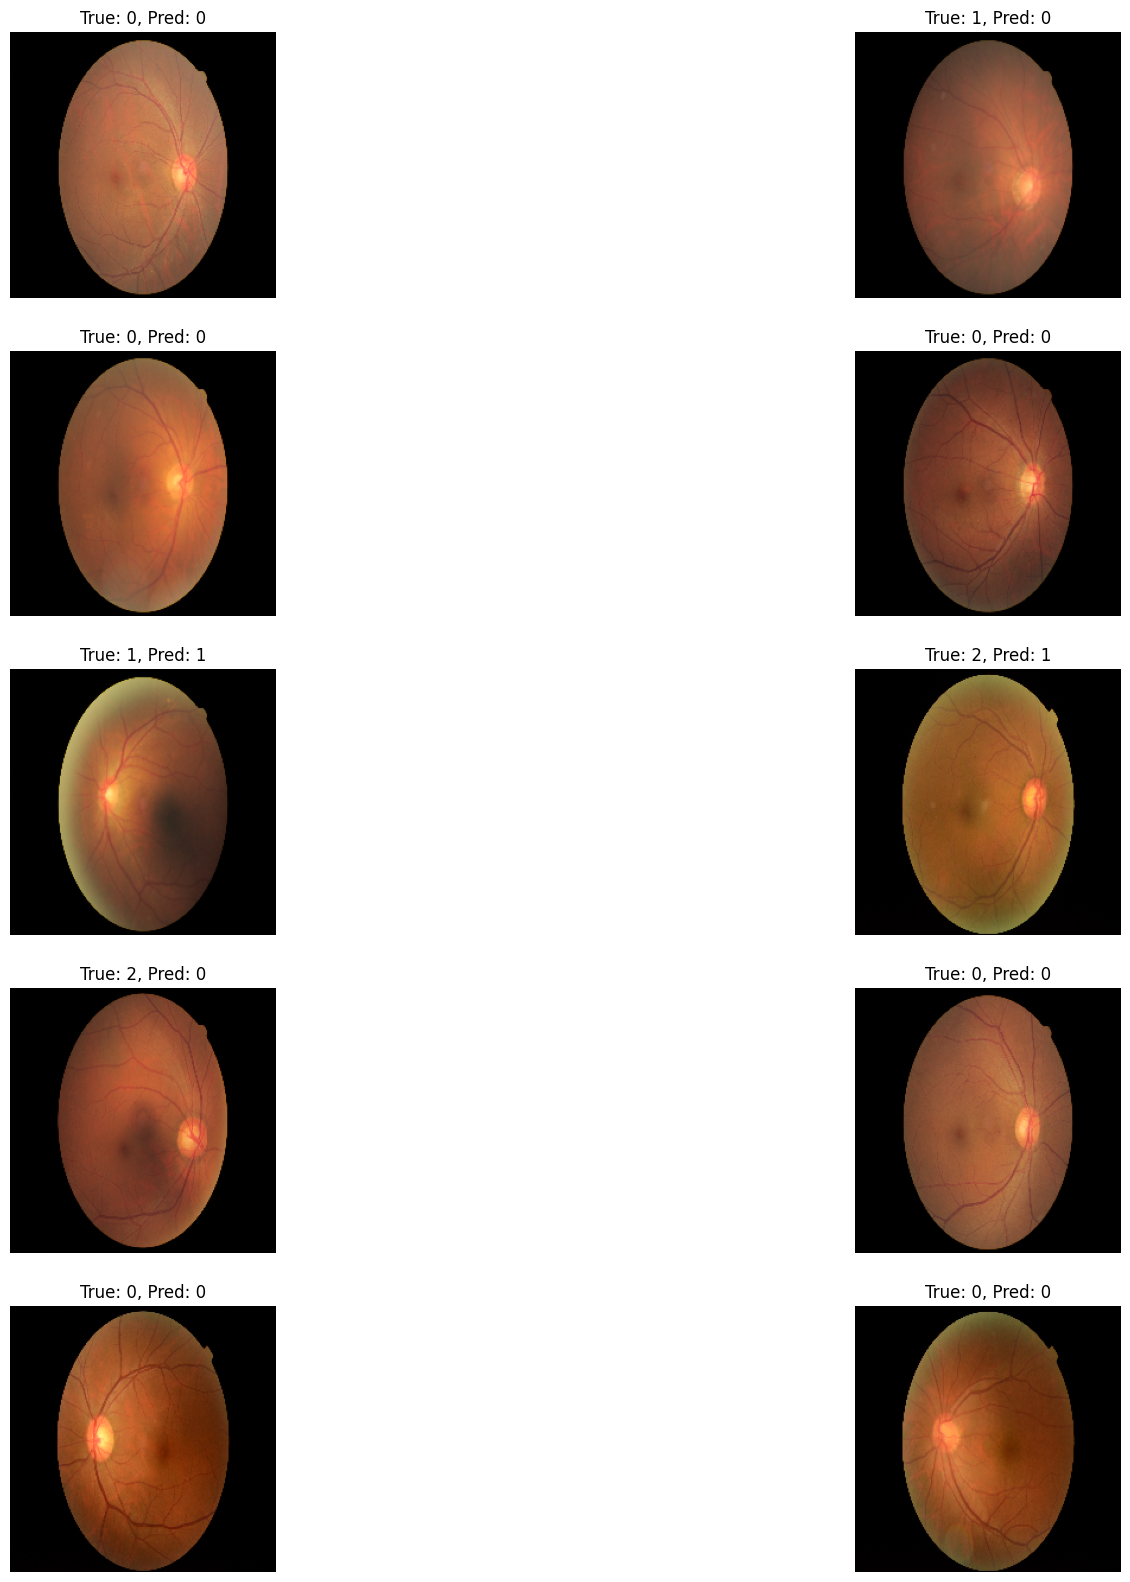

In [ ]:
## Display 10 test samples with actual and predicted labels

def display_samples(images, true_labels, pred_labels, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

display_samples(test_ds, test_lab, y_pred, sample_count=10)

##**5.7. ROC Curve**

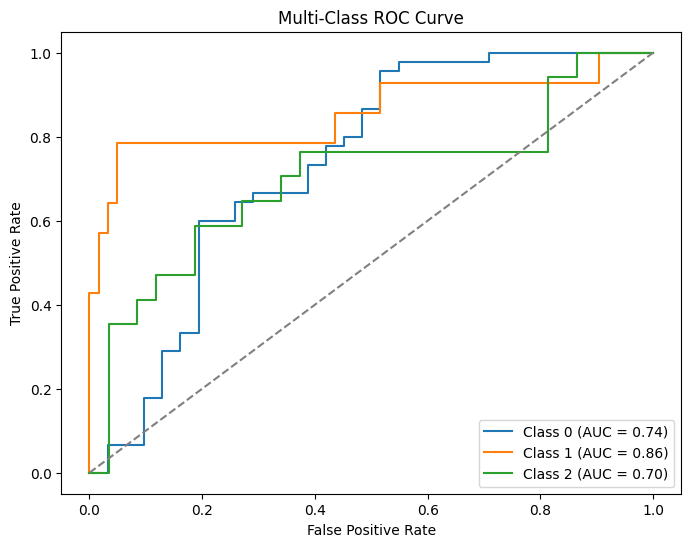

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Assuming `y_test` is one-hot encoded and `y_pred_probs` contains predicted probabilities
n_classes = test_lab_cat.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

#print(y_pred_prob.shape)
#print(test_lab_cat.shape)

#y_pred_prob = model.predict(test_ds)
#y_pred  = y_pred_prob.argmax(axis=1)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_lab_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


#**6. ResNet50 Model Architecture**

##**6.1. Data Preprocessing - Normalisation (Not implemented)**
- Input data were normalised using ```preprocess_input()``` function
- Using the mean and standard deviation values from ImageNet dataset ```mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]```
- Was not implemented in final ResNet50 model as reduced model performances


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

norm_train_ds = preprocess_input(train_ds_res)
norm_val_ds = preprocess_input(val_ds_res)
norm_test_ds = preprocess_input(test_ds_res)


##**6.2. Model Architecture**
- ResNet50 was applied as a feature extractor
- All layers remained frozen in final model and class weights were not adjusted

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape= (224,224,3)
)

for layer in resnet_model.layers: #[-10:] for unfreezing deeper layers
    layer.trainable = False

##**6.3. Assigning Class Weights (Not implemented)**

In [ ]:
# assigning class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = np.unique(train_lab)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes= class_labels,
    y= train_lab
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

##**6.4. Running ResNet50 Model**
- L2 regularisation and dropout layer added to mitigate overfitting due to small dataset and model complexity
- ```GlobalAveragePooling2D()``` directly downsamples feature maps to a single value per channel, producing 1D vector to feed into final output layer
- Running for 20 epochs

In [ ]:
# adding custom layers over Resnet50

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = Sequential([

    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_regularizer=l2(0.01))
]
)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001) #lowered from 0.001

model.compile(
    optimizer=optimizer ,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# reshaping labels due to multi-class data

import tensorflow

train_lab_cat = tensorflow.keras.utils.to_categorical(train_lab, num_classes=3)
# also for the test set
test_lab_cat = tensorflow.keras.utils.to_categorical(test_lab, num_classes=3)
val_lab_cat = tensorflow.keras.utils.to_categorical(val_lab, num_classes=3)

In [ ]:
history = model.fit(
    datagen.flow(train_ds, train_lab_cat, batch_size=32),
    validation_data=(val_ds, val_lab_cat),
    epochs=20,
    shuffle = True #removed class_weights for now

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 95s 8s/step - accuracy: 0.4627 - loss: 5.8984 - val_accuracy: 0.6933 - val_loss: 5.2359
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.5952 - loss: 5.3485 - val_accuracy: 0.7600 - val_loss: 4.9790
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.5859 - loss: 5.1624 - val_accuracy: 0.7467 - val_loss: 4.8420
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.6308 - loss: 5.0337 - val_accuracy: 0.7600 - val_loss: 4.6643
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.6605 - loss: 4.8022 - val_accuracy: 0.7600 - val_loss: 4.5204
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6578 - loss: 4.6443 - val_accuracy: 0.7600 - val_loss: 4.3714
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.6748 - loss: 4.4807 - val_accuracy: 0.7600 - val_loss: 4.2178
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.6811 - loss: 4.3179 - val_accuracy: 0.7733 - val_loss:

##**6.5. Classification Report**

In [ ]:
## model predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_prob = model.predict(test_ds)
y_pred  = y_pred_prob.argmax(axis=1)

print("Accuracy:", accuracy_score(test_lab, y_pred))
print("Classification Report:")
print(classification_report(test_lab, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
Accuracy: 0.6842105263157895
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        45
           1       0.69      0.64      0.67        14
           2       1.00      0.06      0.11        17

    accuracy                           0.68        76
   macro avg       0.79      0.55      0.52        76
weighted avg       0.75      0.68      0.61        76



##**6.6. Confusion Matrix**

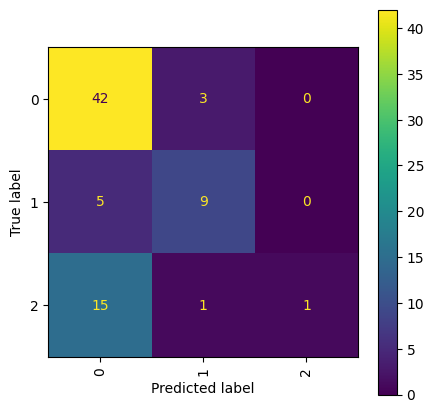

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm  = confusion_matrix(test_lab, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

##**6.7. Display test sample images with true & predicted labels**

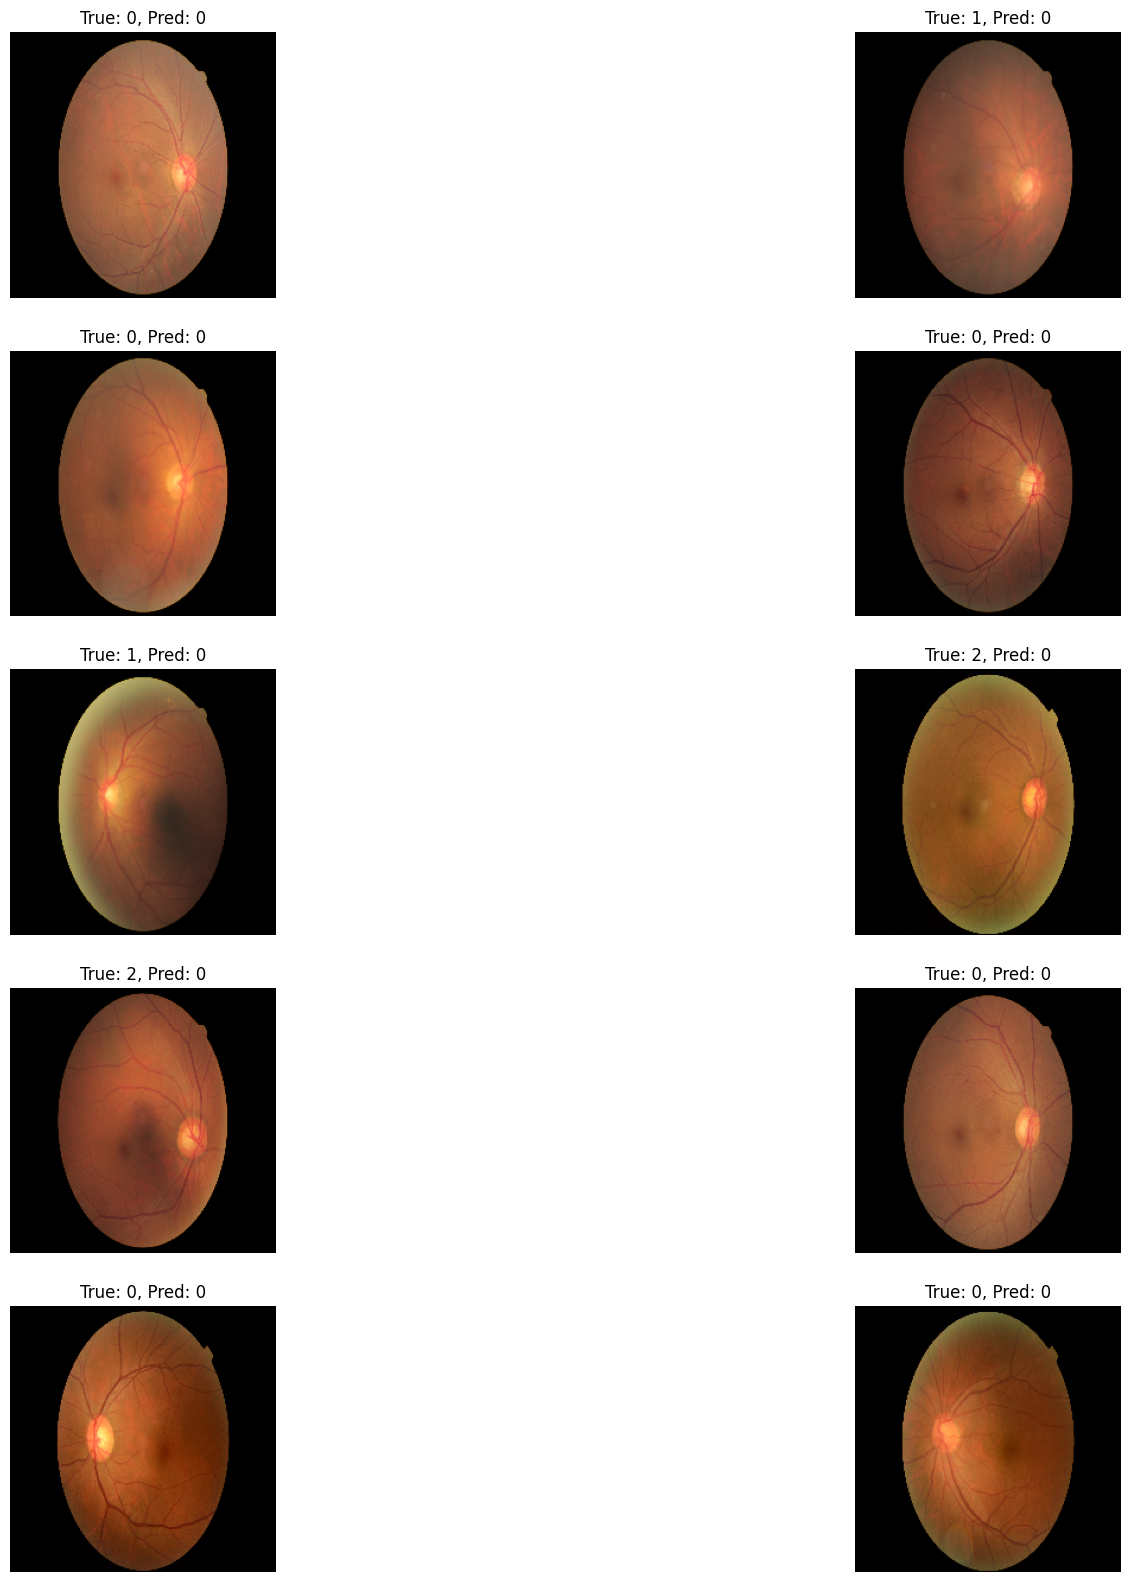

In [ ]:
## Display 10 test samples with actual and predicted labels

def display_samples(images, true_labels, pred_labels, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

display_samples(test_ds, test_lab, y_pred, sample_count=10)

##**6.8. Training and Validation Accuracy & Loss graphs**

In [ ]:
epochs = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

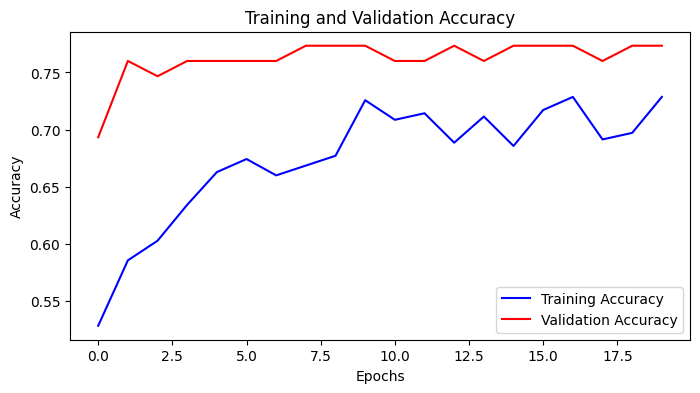

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

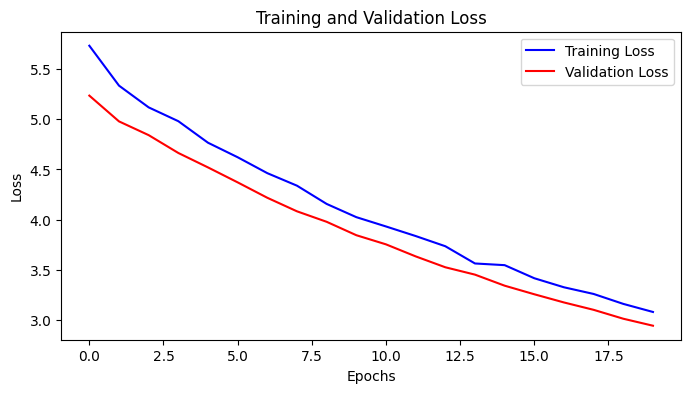

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**6.9. ROC Curve**

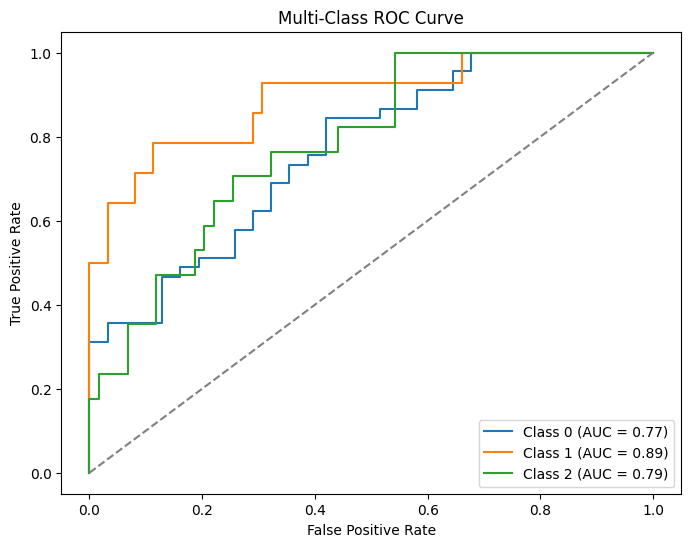

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Assuming `y_test` is one-hot encoded and `y_pred_probs` contains predicted probabilities
n_classes = test_lab_cat.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

#print(y_pred_prob.shape)
#print(test_lab_cat.shape)

#y_pred_prob = model.predict(test_ds)
#y_pred  = y_pred_prob.argmax(axis=1)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_lab_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()



# **7. VGG-16 Model Architecture**


##**7.1. Data Preprocessing - Normalisation (Not implemented)**
- Normalisation with ``` preprocess_input() ``` subtracts the ImageNet RGB mean from each pixel
- Function takes a numpy array with RGB colour channels in the range [0, 255]
- Ultimately was not implemented in final VGG-16 model as it worsened model performance

In [ ]:
### NORMALISATION
#from tensorflow import keras
#from tensorflow.keras.applications.vgg16 import preprocess_input

#norm_train_ds = preprocess_input(train_ds)
#norm_val_ds = preprocess_input(val_ds)
#norm_test_ds = preprocess_input(test_ds)

#norm_ds = preprocess_input(images)

##**7.2. Model Architecture**
- VGG-16 - Popular for its simple and uniform configuration of convolutional and pooling layers
- 16 weighted layers - 13 convolutional layers and 3 fully-connected layers
- All convolutional layers remained frozen for feature extraction purposes in final model
- LeakyReLU activation function mitigates dead neurons


In [ ]:
## trying VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2

base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

#for layer in base_model.layers[-10:]: # for unfreezing 10 deep layers
  #layer.trainable = True

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

### code for LeakyReLU implementation
#x = Flatten()(base_model.output)
#x = Dense(256)(x)
#x = LeakyReLU(alpha=0.01)(x)
#x = Dropout(0.5)(x)
#output = Dense(3, activation='softmax')(x)

# Create the new model
model = keras.models.Model(inputs=base_model.input, outputs=output)

## **7.3. Focal loss function (Not implemented)**


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss_multiclass(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)

        return K.mean(weight * cross_entropy)
    return loss

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=focal_loss_multiclass(alpha=0.25, gamma=2.0),
              metrics=["accuracy"])


##**7.4. Running VGG-16 Model**
- VGG-16 model was ran for 50 epochs
- Class weights were not assigned in final model

In [ ]:
from tensorflow.keras.optimizers import Adam


optimizer = Adam(learning_rate=0.0005) #lowered from 0.001

model.compile(
    optimizer=optimizer ,
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
# reshaping labels due to multi-class data to one-hot encoding labels

import tensorflow

train_lab_cat = tensorflow.keras.utils.to_categorical(train_lab, num_classes=3)
test_lab_cat = tensorflow.keras.utils.to_categorical(test_lab, num_classes=3)
val_lab_cat = tensorflow.keras.utils.to_categorical(val_lab, num_classes=3)

In [ ]:
# assigning class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = np.unique(train_lab)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes= class_labels,
    y= train_lab
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

In [ ]:
history = model.fit(
    datagen.flow(train_ds, train_lab_cat, batch_size=32),
    validation_data=(val_ds, val_lab_cat),
    epochs=50,
    shuffle = True # removed class_weights for now

)

##**7.5. Classification report**

In [ ]:
## model predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_prob = model.predict(test_ds)
y_pred  = y_pred_prob.argmax(axis=1)

print("Accuracy:", accuracy_score(test_lab, y_pred))
print("Classification Report:")
print(classification_report(test_lab, y_pred))

##**7.6. Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm  = confusion_matrix(test_lab, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

##**7.7. Display test sample images with true & predicted labels**

In [ ]:
## Display 10 test samples with actual and predicted labels

def display_samples(images, true_labels, pred_labels, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

display_samples(test_ds, test_lab, y_pred, sample_count=10)

##**7.8. Training and Validation Accuracy & Loss graphs**


In [ ]:
epochs = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**7.9. ROC Curves**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


n_classes = test_lab_cat.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

#print(y_pred_prob.shape)
#print(test_lab_cat.shape)

#y_pred_prob = model.predict(test_ds)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_lab_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()
